# Features

In [110]:
from pprint import pprint
from glob import glob
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from PIL import Image
import wordcloud
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
!pwd

/Users/chris/github/reddit_nlp


In [5]:
from util import databases
from util import dataloader
from util import grid_models
from util.reddit_functions import Reddit, Visualizer

In [6]:
!pwd

/Users/chris/github/reddit_nlp/util


In [7]:
# list to get data for
subreddit_list = ['datascience','machinelearning','dataengineering','python','aws']

# load data using dataloader module
df = dataloader.data_selector(subreddit_list, source='sqlite')

# what we expected?
df.sample(10)

Connection to SQLite DB successful


,title,subreddit,date
18078,pypsexec - How to launch a remote Win10 GUI ap...,python,2020-04-14
15411,[Source code with demo] Here is my python impl...,datascience,2020-04-14
14512,AWS Directory Service w/ MFA,aws,2020-04-14
16529,[D] Is the Covid-19 crisis the rock on which t...,machinelearning,2020-04-14
13696,Any Data Engineers here in education?,dataengineering,2020-04-10
19419,What is the most optimized way to the upload l...,aws,2020-04-20
19280,RDS export snapshot to S3,aws,2020-04-20
18800,Free/Open Source Data Lineage Tool?,dataengineering,2020-04-14
15835,IBM data science course completion in 30 days,datascience,2020-04-14
22316,Hashing and Equality in Python,python,2020-04-20


In [8]:
X = df['title']
y = df['subreddit']

In [9]:
label_encoder = LabelEncoder()
label_encoder.fit(y)
y = label_encoder.transform(y)
label_encoder.classes_

array(['aws', 'dataengineering', 'datascience', 'machinelearning',
       'python'], dtype=object)

In [10]:
encoded = df.copy()

In [11]:
encoded['label'] = y

In [12]:
encoded.sample(30)

,title,subreddit,date,label
18063,Using Python to automate your link building pr...,python,2020-04-14,4
6217,How would You visualize the evolution of Coron...,datascience,2020-04-02,2
18621,Do you ever feel like quitting because fuck th...,dataengineering,2020-04-14,1
22263,For all you work from home people out there......,python,2020-04-20,4
5976,Need advice regarding on going tussle in Data ...,datascience,2020-04-02,2
11781,[P] Gold: Reinforcement Learning in Go,machinelearning,2020-04-10,3
12927,PDF to OpenCV as page by page using PyMuPDF li...,python,2020-04-10,4
2750,Getting explainable ML models by evolving comp...,machinelearning,2020-03-29,3
12514,Finally was able to solve OpenAI's Cartpole us...,python,2020-04-10,4
872,"Everywhere I read about oatuh 2 tokens, they s...",aws,2020-03-29,0


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

In [14]:
useless_words = set(['using', 'lambda', 's3', 'does', 'looking', 'help', 'new', 'data', 'science', 'machine', 'learning', 'use', 'need', 'engineer', 'engineering'])

custom_stop_words = ENGLISH_STOP_WORDS.union(subreddit_list, useless_words)

In [20]:
tfidf = TfidfVectorizer(max_df=0.7, max_features=6000, ngram_range=(1,2), stop_words=custom_stop_words)
logreg = LogisticRegression(max_iter=1000)
pipe = Pipeline([('tfidf', tfidf),('logreg', logreg)])

In [21]:
model = pipe.fit(X_train, y_train)

In [22]:
model.score(X_test, y_test)

0.8582189487780382

In [28]:
model.named_steps.logreg.coef_

array([[ 0.42964408, -0.03229263, -0.03229263, ...,  0.6089208 ,
         1.81615662, -0.37223161],
       [-0.13624354, -0.06154156, -0.06154156, ..., -0.27536211,
        -0.21081438, -0.43465635],
       [-0.73895021,  0.2345106 ,  0.2345106 , ..., -0.20752981,
        -0.57431152, -0.39320319],
       [-0.05684179, -0.07262612, -0.07262612, ..., -0.15585854,
        -0.4744389 ,  1.09543266],
       [ 0.50239146, -0.06805029, -0.06805029, ...,  0.02982966,
        -0.55659183,  0.1046585 ]])

# TODO

[ ] - I want to make this a function of some sort,   
[ ] - Make function check for linear models with coefs  
[ ] - and also I want to have the option to overlay all or some of them on top of each other so that can compare the relative sizes of the coefs.

In [127]:
coef_dict = {}
for i, sub in enumerate(label_encoder.classes_):
    print(sub)
    coef_dict[sub] = pd.DataFrame(
                        data=model.named_steps.logreg.coef_[i],
                        index=model.named_steps.tfidf.get_feature_names())



aws
dataengineering
datascience
machinelearning
python


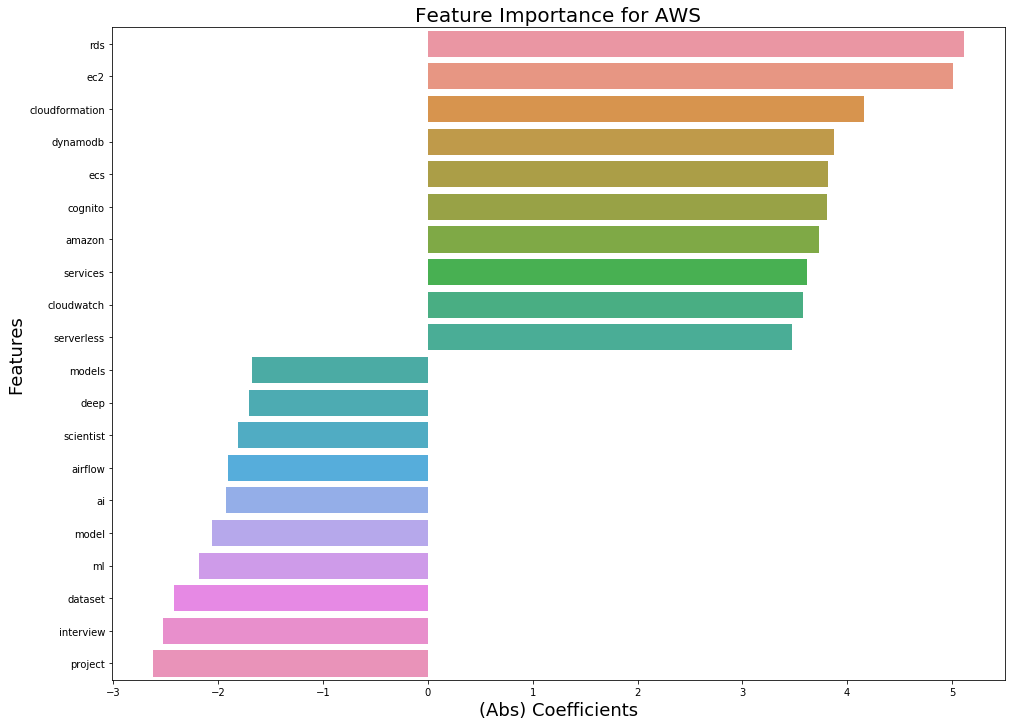

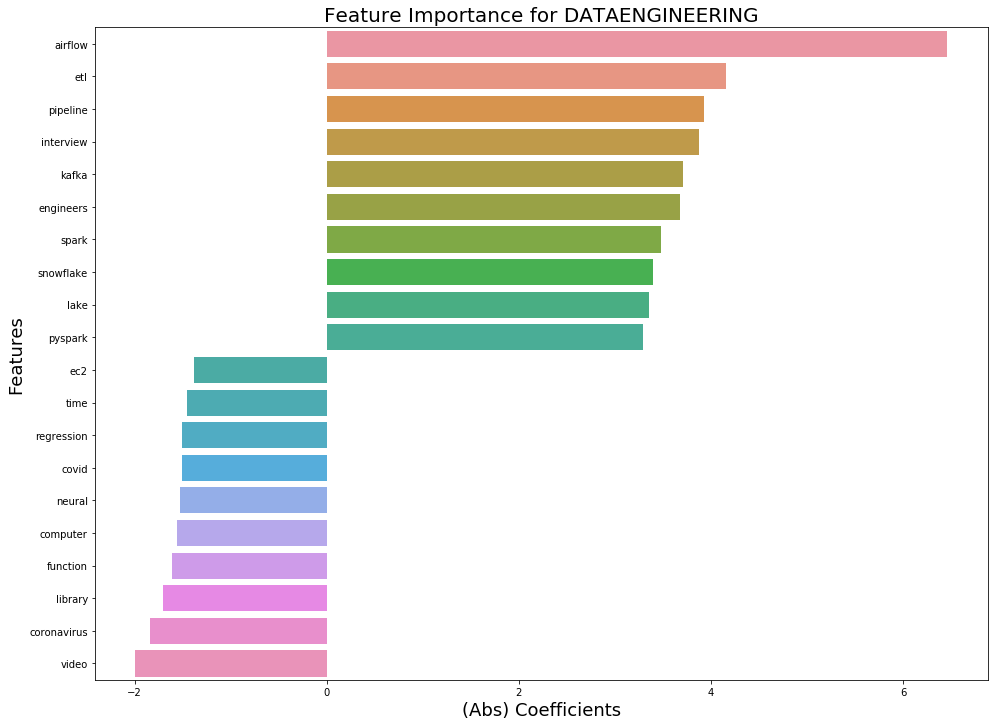

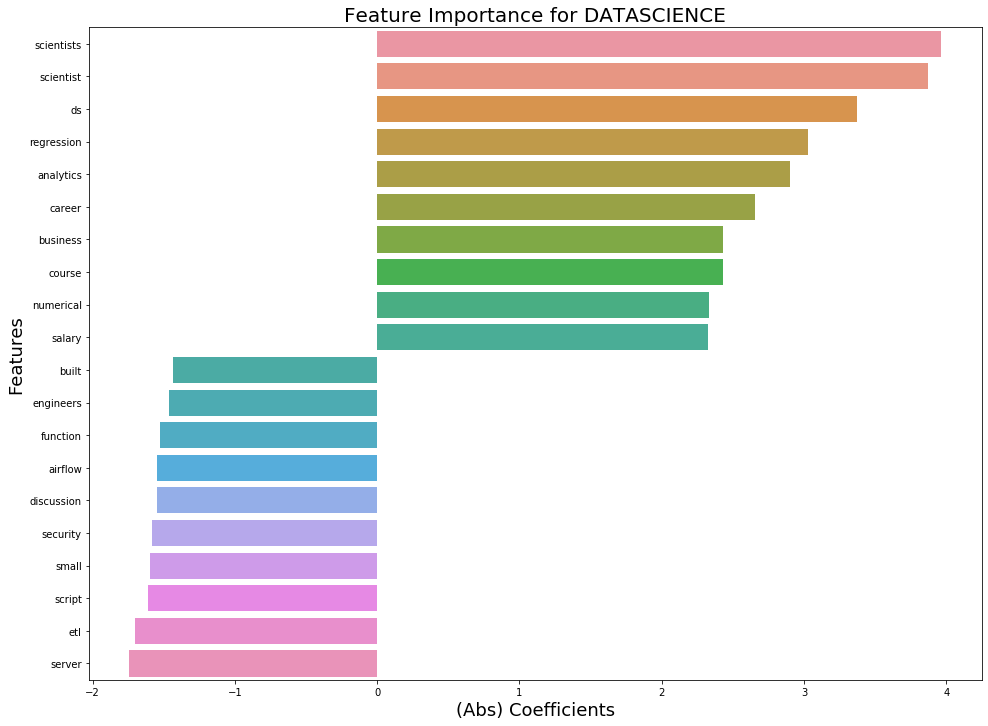

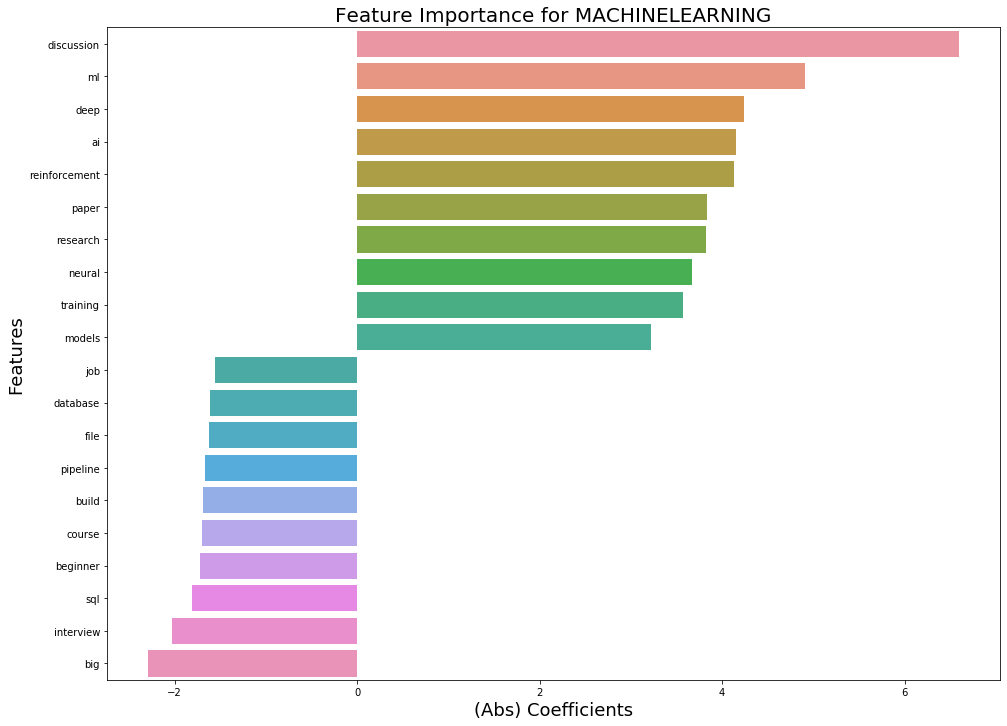

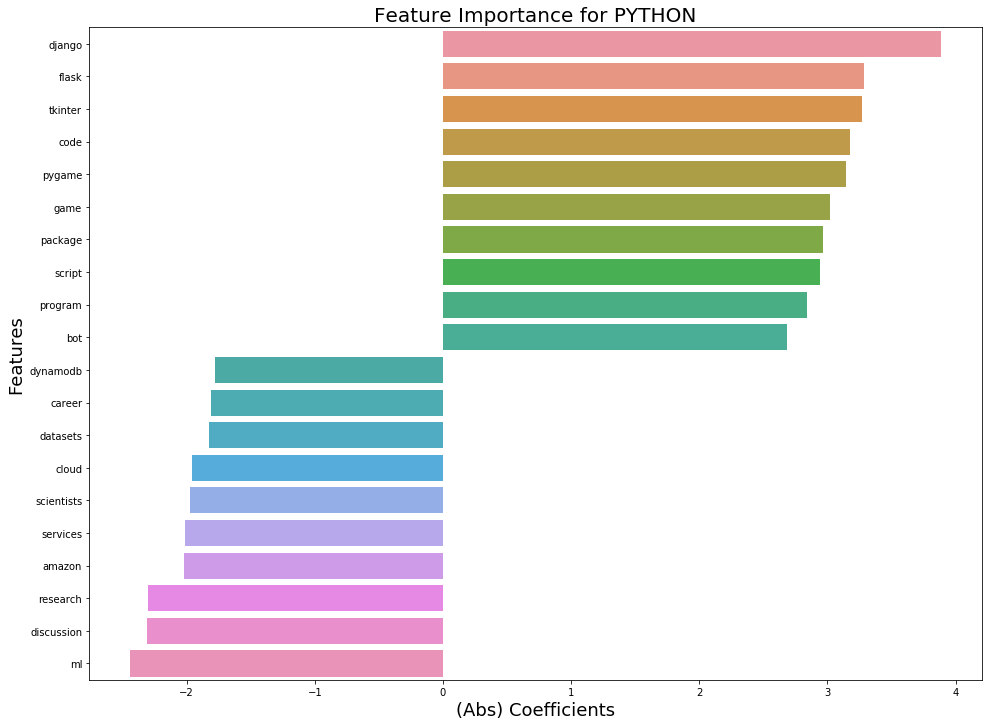

In [128]:
for sub, df in coef_dict.items():
    df['abs'] = df[0].abs()




    plt.figure(figsize=(16, 12))
    plt.title(f'Feature Importance for {sub.upper()}', fontsize=20)
    plt.ylabel('Features', fontsize=18)
    plt.xlabel('(Abs) Coefficients', fontsize=18)

    top_10 = df.sort_values('abs', ascending=False)[0].head(10)
    bottom_10 = df.sort_values(0, ascending=False)[0].tail(10)
    top_and_bottom = pd.DataFrame(data=top_10.append(bottom_10))

    sns.barplot(x=top_and_bottom[0], y=top_and_bottom.index)
    plt.ylabel('Features', fontsize=18)
    plt.xlabel('(Abs) Coefficients', fontsize=18);

# Predictions

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)

In [ ]:
df_cm = pd.DataFrame(cm, columns=subreddit_list, index=subreddit_list)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
df_cm

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=2)
sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, cmap='Greens', ax=ax, )
fontdict={'fontsize': 16}
ax.set_yticklabels(labels=subreddit_list, rotation='horizontal', fontdict=fontdict)
ax.set_xticklabels(labels=subreddit_list, rotation=20, fontdict=fontdict)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

In [ ]:
mcm = multilabel_confusion_matrix(y_test, y_pred)
mtn = mcm[:, 0, 0]
mtp = mcm[:, 1, 1]
mfn = mcm[:, 1, 0]
mfp = mcm[:, 0, 1]
print(mcm)

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=len(subreddit_list),
                       figsize=(12, 6*len(subreddit_list)))

for i, cm in enumerate(mcm):
    df_cm = pd.DataFrame(cm)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sns.heatmap(df_cm, annot=True, fmt="d", cbar=False,
                cmap='Purples', ax=ax[i, 0])

    ax[i, 0].set_yticklabels(labels=[1, 0], rotation='horizontal')
    ax[i, 0].set_xticklabels(labels=[1, 0])
    ax[i, 0].xaxis.tick_top()
    ax[i, 0].xaxis.set_label_position('top')
    ax[i, 0].set_title(subreddit_list[i].upper())

    tn, fp, fn, tp = cm.ravel()
    specif = tn / (tn + fp)

    sens = tp / (tp + fn)
    box_text = f'''Subreddit: {subreddit_list[i].upper()}\n\nSpecificity: {round(specif,4)}\n\nSensitivity: {round(sens,4)}'''
    ax[i, 1].text(0.5, 0.5, box_text, horizontalalignment='center',
                  verticalalignment='center', fontsize=24)
    ax[i, 1].set_axis_off()


plt.tight_layout()

In [ ]:
print(classification_report(y_test, y_pred, digits=3, target_names=subreddit_list))

<h1>TODO:</h1>

1. Make it have the roc for each sub, have to get into the original df where subname equals indexes?
2. Plot confusion matrix
3. Make a notebook to test the confusion matrixes one by one with each individual model.

In [ ]:
y_test.index

In [ ]:
auc = roc_auc_score(y_test, y_pred)
auc

In [ ]:
probs = model.predict_proba(X_test)[:,1]

In [ ]:
# not multiclass
fpr, tpr, thresholds = roc_curve(y_test, probs)

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc})', color='r', marker='D')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)', size=16)
plt.ylabel('True Positive Rate (Sensitivity)', size=16)
plt.title('ROC Curve', size=20)
plt.legend(fontsize=14);

In [ ]:
x1 = np.random.normal(0, 0.8, 1000) x2 = np.random.normal(-2, 1, 1000) x3 = np.random.normal(3, 2, 1000)
kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=40)
plt.hist(x1, **kwargs) plt.hist(x2, **kwargs) plt.hist(x3, **kwargs);

In [ ]:
# Create figure.
plt.figure(figsize = (10,7))

# Create histogram of observations.
plt.hist(probs, bins=25, color='b')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18);

In [ ]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
hst0 = plt.hist(probs[y_test == 0],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Technology',)

hst1 = plt.hist(probs[y_test == 1],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Science')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = max(hst1[0].max(), hst0[0].max()), # Max of the two highest respective hist values
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Science)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

# Thanks to Matt Brems for the colorful graphs! :)